        Date  HomePriceIndex  InterestRate  UnemploymentRate      GDP  TCJA
0 1987-01-01          63.735         14.35               6.6  37132.0     0
1 1987-04-01          64.973          6.22               6.3  37454.0     0
2 1987-07-01          66.786          6.07               6.1  37685.0     0
3 1987-10-01          67.902          7.71               6.0  38238.0     0
4 1988-01-01          68.582          6.89               5.7  38359.0     0


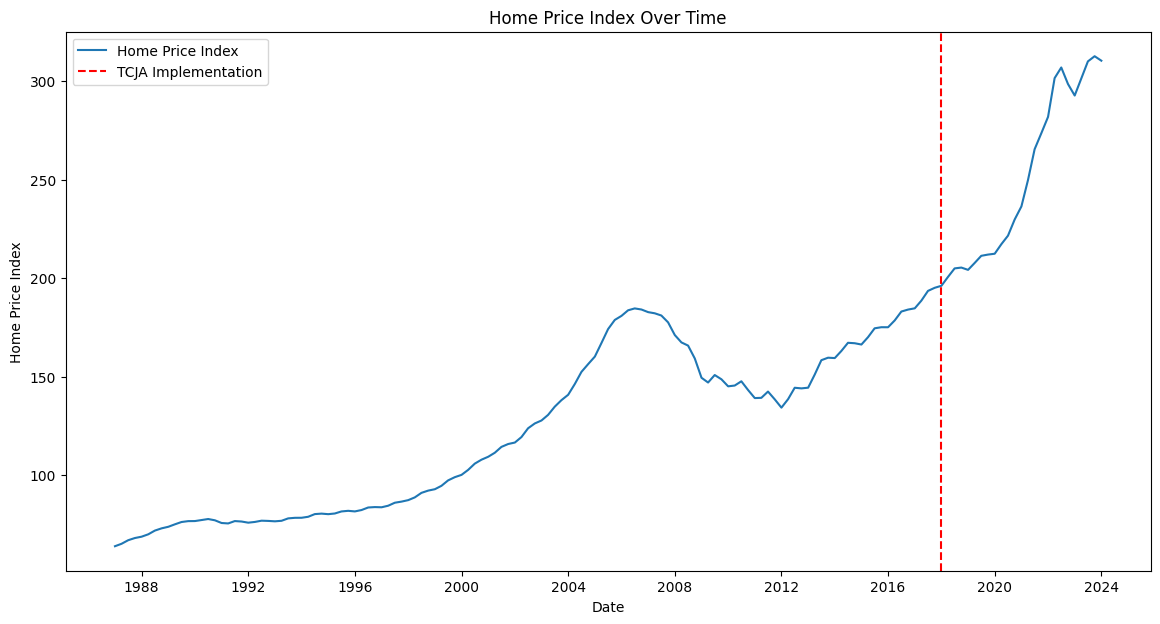

                            OLS Regression Results                            
Dep. Variable:         HomePriceIndex   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     521.3
Date:                Fri, 07 Jun 2024   Prob (F-statistic):           1.48e-84
Time:                        07:56:03   Log-Likelihood:                -625.71
No. Observations:                 149   AIC:                             1261.
Df Residuals:                     144   BIC:                             1276.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -254.4125     23.933  

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


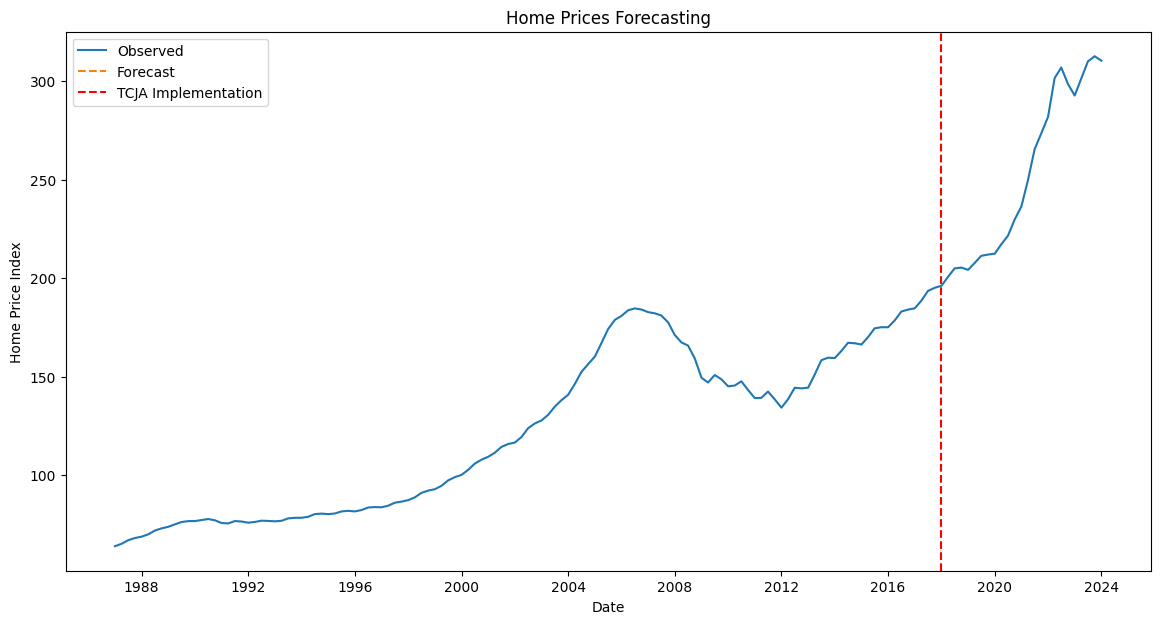

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

home_prices = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?id=CSUSHPINSA')
home_prices.columns = ['Date', 'HomePriceIndex']
home_prices['Date'] = pd.to_datetime(home_prices['Date'])

interest_rates = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?id=DFF')
interest_rates.columns = ['Date', 'InterestRate']
interest_rates['Date'] = pd.to_datetime(interest_rates['Date'])

unemployment_rate = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?id=UNRATE')
unemployment_rate.columns = ['Date', 'UnemploymentRate']
unemployment_rate['Date'] = pd.to_datetime(unemployment_rate['Date'])


gdp = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?id=A939RX0Q048SBEA')
gdp.columns = ['Date', 'GDP']
gdp['Date'] = pd.to_datetime(gdp['Date'])

merged_df = pd.merge(home_prices, interest_rates, on='Date')
merged_df = pd.merge(merged_df, unemployment_rate, on='Date')
merged_df = pd.merge(merged_df, gdp, on='Date')


merged_df['TCJA'] = (merged_df['Date'] >= '2017-12-22').astype(int)


merged_df.interpolate(method='linear', inplace=True)

merged_df.to_csv('merged_economic_data.csv', index=False)


print(merged_df.head())


plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['HomePriceIndex'], label='Home Price Index')
plt.axvline(pd.to_datetime('2017-12-22'), color='r', linestyle='--', label='TCJA Implementation')
plt.xlabel('Date')
plt.ylabel('Home Price Index')
plt.title('Home Price Index Over Time')
plt.legend()
plt.show()

# Difference-in-Differences Analysis
import statsmodels.formula.api as smf

# Define the regression model for DiD
model = smf.ols('HomePriceIndex ~ TCJA + InterestRate + UnemploymentRate + GDP', data=merged_df).fit()


print(model.summary())

# Forecasting using SARIMAX

train_data = merged_df[merged_df['Date'] < '2018-01-01']
test_data = merged_df[merged_df['Date'] >= '2018-01-01']

# Fit the SARIMA model
sarimax_model = SARIMAX(train_data['HomePriceIndex'],
                        exog=train_data[['InterestRate', 'UnemploymentRate', 'GDP']],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12)).fit()

# Forecast future values
forecast = sarimax_model.get_forecast(steps=len(test_data), exog=test_data[['InterestRate', 'UnemploymentRate', 'GDP']])
forecast_index = test_data['Date']
forecast_df = pd.DataFrame({'Forecast': forecast.predicted_mean}, index=forecast_index)

plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['HomePriceIndex'], label='Observed')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--')
plt.axvline(pd.to_datetime('2017-12-22'), color='r', linestyle='--', label='TCJA Implementation')
plt.xlabel('Date')
plt.ylabel('Home Price Index')
plt.title('Home Prices Forecasting')
plt.legend()
plt.show()


The OLS regression results provide insights into the impact of various factors, including the Tax Cuts and Jobs Act (TCJA), on the US home prices. Here's a detailed interpretation:

**Key Metrics**

R-squared (0.935): This indicates that 93.5% of the variability in the HomePriceIndex can be explained by the model. This suggests a very good fit of the model to the data.

F-statistic (521.3) and Prob (F-statistic) (1.48e-84): The high F-statistic and the extremely low p-value indicate that the overall model is statistically significant.


**Coefficients and their Interpretations**

Intercept (-254.4125): The negative intercept value indicates the expected value of the HomePriceIndex when all other predictors are zero, which in practice, might not have a meaningful interpretation but is part of the linear model structure.

TCJA (33.5749):

**Coefficient (33.5749)**: This positive coefficient suggests that the implementation of the TCJA is associated with an increase in the HomePriceIndex by approximately 33.57 units, holding other factors constant.

**t-value (6.519) and P>|t| (0.000):** The t-value is high and the p-value is extremely low, indicating that the effect of TCJA on the HomePriceIndex is statistically significant. Therefore, we can conclude with high confidence that the TCJA has a positive and significant impact on US home prices.

**InterestRate (3.6647):** Higher interest rates are associated with an increase in home prices, which might seem counterintuitive and could warrant further investigation.

**UnemploymentRate (1.8479):** Although this coefficient is positive, the p-value (0.072) is slightly above the conventional 0.05 threshold, suggesting that the impact of the unemployment rate is not statistically significant at the 5% level.

**GDP (0.0071):** A very small positive coefficient but highly significant (p-value = 0.000), indicating that GDP has a significant positive impact on home prices.

**Other Model Diagnostics**
**Omnibus (0.199) and Prob(Omnibus) (0.905):** These values suggest that the residuals are normally distributed, which is a good sign for the model assumptions.

**Jarque-Bera (0.080) and Prob(JB) (0.961):** Again, these indicate that the residuals are normally distributed.
Skew (-0.055) and Kurtosis (3.026): These values are close to those of a normal distribution.

**Durbin-Watson (0.162):** This indicates potential autocorrelation in the residuals, which might need to be addressed for more accurate inference.

**Conclusion**

The results show that the TCJA has a significant positive impact on US home prices, increasing the HomePriceIndex by approximately 33.57 units. This suggests that the tax policy changes brought by TCJA likely contributed to higher home prices. Other factors like interest rates and GDP also have significant effects, but the interpretation of interest rates needs careful consideration. The unemployment rate, while positive, is not statistically significant at the 5% level.